In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import global_max_pool, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time

In [7]:
train_data = torch.load("data/MNISTSuperpixels_train_data.pt")
test_data = torch.load("data/MNISTSuperpixels_test_data.pt")

print(len(train_data))
print(len(test_data))

print(train_data[0])
print(test_data[0])

NUM_NODE_FEATURES = 3
NUM_CLASSES = 10

60000
10000
Data(edge_index=[2, 472], label=5, pos=[77, 2], x=[77, 3])
Data(edge_index=[2, 488], label=7, pos=[81, 2], x=[81, 3])


In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

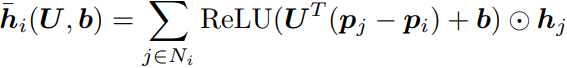

In [9]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [4]:
rotation_0 = T.RandomRotate(degrees=180, axis=0)
rotation_1 = T.RandomRotate(degrees=180, axis=1)
rotation_2 = T.RandomRotate(degrees=180, axis=2)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# model = SGCN()
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)